In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def softmax(A,p=1):
    return (np.exp(A)**p)/np.sum((np.exp(A)**p),axis=0)

# A affinity, th threshold vector (value of each stage), s the stage, p power of competition

def softmutualcompetition_th_accordingtohardmutualcompetition_(A, th, s, p, sparsity):
    #soft competition in two directions
    sparsity=sparsity[s]

    V = np.exp(A*p[s])

    N = np.zeros(V.shape)
    s1 = np.sum(V,axis=1)
    s2 = np.sum(V, axis=0)
    for i in range(N.shape[0]):
        for j in range(N.shape[1]):
            N[i,j] = s1[i] + s2[j] - V[i,j]
    
    R = V /N
    
    R[V==0]=0
        
    th_ = np.sort(R.flatten())[::-1][int(sparsity*len(R.flatten()))]
    res = np.zeros(V.shape)
    res[R>th_] = 1
    res[A==-np.inf]=0

    return res

def nocompetition_th_accordingtohardmutualcompetition(A, th, s, sparsity):
    sparsity=sparsity[s]
    th_ = np.sort(A.flatten())[::-1][int(sparsity*len(A.flatten()))]
    res = np.zeros(A.shape)
    res[A>th_] = 1

    return res

def hardmutualcompetition(A, th, s):
    th_ = th[s]
    J = np.zeros(A.shape[0])
    V = np.zeros(A.shape[1])
    res = np.zeros(A.shape)
    order = np.unravel_index(A.flatten().argsort()[::-1], A.shape)
    for i in range(len(A.flatten())):
        j = order[0][i]
        v = order[1][i]
        if J[j]<th_ and V[v]<th_:
            res[j,v]=1
            J[j]+=1
            V[v]+=1
    res[A==-np.inf]=0

    return res
        
def compute_label_tensor(binarizationfunction, th, *args):
    #Y = np.zeros((nj, nv, 4))
    Y = np.zeros(A.shape)
    
    Y[:,:,0] = binarizationfunction(A[:,:,0], th, 0, *args)
    for i in range(1,Y.shape[2]):
        A[:,:,i][Y[:,:,i-1]==0] = -np.inf
        Y[:,:,i] = binarizationfunction(A[:,:,i], th, i, *args)

    Y = Y.astype(bool)
    
    
    return Y

def nocompetition(A, th, s):
    th_ = th[s]
    res = np.zeros(A.shape)
    res[A>th_] = 1
    return res

# Here, data sets are generated ad saved

In [38]:
nj, mj = 1000, 20
nv, mv = 1000, 20
ns = 4

Xj, Xv = np.random.normal(size=(nj,mj)), np.random.normal(size=(nv,mv))

In [4]:
cov = 0 # 0 #0.5
μ=1 # 0 #1

nj, mj = 1000, 20
nv, mv = 1000, 20
ns = 4
th = [125,25,5,1]
p = [1]*4


for repetition in range(5):
    COV = np.array([[1, cov, cov, cov],
                    [cov, 1, cov, cov],
                    [cov, cov, 1, cov],
                    [cov, cov, cov, 1]
                    ])
    C = np.linalg.cholesky(COV)
    Xn = np.random.normal(size=(mj,mv,ns))
    Xn = np.einsum('ijk, lk->ijl',Xn,C,optimize='greedy')
    Xn = Xn + μ*np.ones(Xn.shape) #μ*np.asarray([np.diag(np.ones(20))]*4).transpose()

    A = np.einsum('iu, jv, uvk->ijk',Xj,Xv,Xn,optimize='greedy')
    Yhardmutualcompetition = compute_label_tensor(hardmutualcompetition, th=th)
    np.save('Y_hardmutualcompetition_th{}mu{}cov{}repetition{}'.format(th,μ,cov,repetition), Yhardmutualcompetition)

    A = np.einsum('iu, jv, uvk->ijk',Xj,Xv,Xn,optimize='greedy')
    #Ynocompetition = compute_label_tensor(nocompetition_th_accordingtohardmutualcompetition,th=th)
    Ynocompetition = compute_label_tensor(nocompetition_th_accordingtohardmutualcompetition,th, np.mean(Yhardmutualcompetition, axis=(0,1)))

    np.save('Y_nocompetition_th{}mu{}cov{}repetition{}'.format(th,μ,cov,repetition), Ynocompetition)

    A = np.einsum('iu, jv, uvk->ijk',Xj,Xv,Xn,optimize='greedy')
    #Ysoftmutualcompetition = compute_label_tensor(softmutualcompetition_th_accordingtohardmutualcompetition_,th,p)
    Ysoftmutualcompetition = compute_label_tensor(softmutualcompetition_th_accordingtohardmutualcompetition_,th,p,np.mean(Yhardmutualcompetition, axis=(0,1)))
    np.save('Y_softmutualcompetitio_th{}mu{}cov{}repetition{}'.format(th,μ,cov,repetition), Ysoftmutualcompetition)

    np.save('Xj_th{}mu{}cov{}repetition{}'.format(th,μ,cov,repetition),Xj)
    np.save('Xv_th{}mu{}cov{}repetition{}'.format(th,μ,cov,repetition),Xv)

/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


# Here, exploratory and visualizations are created

In [4]:
import seaborn as sns

In [39]:
# https://math.stackexchange.com/questions/446093/generate-correlated-normal-random-variables

Xj, Xv = np.random.normal(size=(nj,mj)), np.random.normal(size=(nv,mv))



cov = 0 # 0 #0.5
μ=1 # 0 #1

COV = np.array([[1, cov, cov, cov],
                [cov, 1, cov, cov],
                [cov, cov, 1, cov],
                [cov, cov, cov, 1]
                ])
C = np.linalg.cholesky(COV)

Xn = np.random.normal(size=(mj,mv,ns))
print(np.std(Xn), np.std(Xn[:,:,0]), np.std(Xn[:,:,1]))
print(np.cov(Xn[:,:,0].flatten(), Xn[:,:,1].flatten())[0,1], np.cov(Xn[:,:,1].flatten(), Xn[:,:,2].flatten())[0,1], np.cov(Xn[:,:,2].flatten(), Xn[:,:,3].flatten())[0,1])
print()

Xn = np.einsum('ijk, lk->ijl',Xn,C,optimize='greedy')
Xn = Xn + μ*np.ones(Xn.shape) #μ*np.asarray([np.diag(np.ones(20))]*4).transpose()
print(np.std(Xn), np.std(Xn[:,:,0]), np.std(Xn[:,:,1]))
print(np.cov(Xn[:,:,0].flatten(), Xn[:,:,1].flatten())[0,1], np.cov(Xn[:,:,1].flatten(), Xn[:,:,2].flatten())[0,1], np.cov(Xn[:,:,2].flatten(), Xn[:,:,3].flatten())[0,1])



1.0038046850391216 1.0473076595900666 1.0084171032044664
-0.01272111286148538 -0.056526949247467255 0.013480483478575844

1.0038046850391216 1.0473076595900666 1.0084171032044664
-0.012721112861485364 -0.05652694924746728 0.013480483478575826


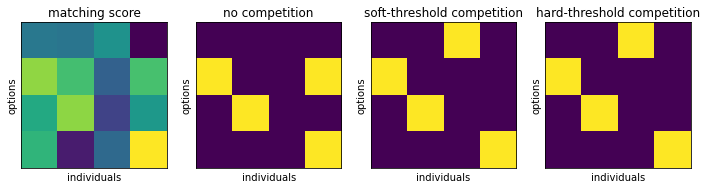

In [40]:

A = np.random.normal(size=(4,4))

Yhc = hardmutualcompetition(A,[1],0)
Ync = nocompetition_th_accordingtohardmutualcompetition(A, [1], 0, sparsity=[np.mean(Yhc)])
Ysc = softmutualcompetition_th_accordingtohardmutualcompetition_(A, [1], 0, p=[1], sparsity=[np.mean(Yhc)])

fig, ax = plt.subplots(1,4, figsize=(4*3,1*3))
ax[0].imshow(A)
ax[1].imshow(Ync)
ax[2].imshow(Ysc)
ax[3].imshow(Yhc)

ax[0].set_title('matching score')
ax[1].set_title('no competition')
ax[2].set_title('soft-threshold competition')
ax[3].set_title('hard-threshold competition')

#for i in range(4):
#    ax[i].axis('off')

for i in range(4):
    ax[i].set_xlabel('individuals')
    ax[i].set_ylabel('options')
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticklabels([]) 
    ax[i].set_yticks([])

plt.show()


In [41]:
th = [125,25,5,1]

A = np.einsum('iu, jv, uvk->ijk',Xj,Xv,Xn,optimize='greedy')
Yhardmutualcompetition = compute_label_tensor(hardmutualcompetition, th=th)

A = np.einsum('iu, jv, uvk->ijk',Xj,Xv,Xn,optimize='greedy')
Ynocompetition = compute_label_tensor(nocompetition_th_accordingtohardmutualcompetition,th, np.mean(Yhardmutualcompetition, axis=(0,1)))

p = [1]*4
A = np.einsum('iu, jv, uvk->ijk',Xj,Xv,Xn,optimize='greedy')
Ysoftmutualcompetition = compute_label_tensor(softmutualcompetition_th_accordingtohardmutualcompetition_,th,p,np.mean(Yhardmutualcompetition, axis=(0,1)))

/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [42]:
np.mean(Yhardmutualcompetition, axis=(0,1))

array([0.124734, 0.024862, 0.004906, 0.000904])

In [43]:
np.mean(Ysoftmutualcompetition, axis=(0,1))

array([0.124734, 0.024862, 0.004906, 0.000904])

In [44]:
np.mean(Ynocompetition, axis=(0,1))

array([0.124734, 0.024862, 0.004906, 0.000904])

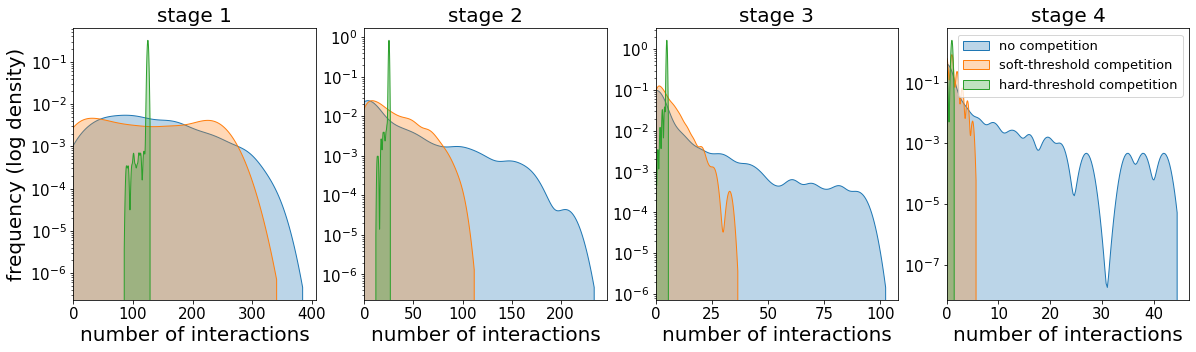

In [47]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
for stage in range(4):
    density=False
    #ax[stage].hist(np.sum(Yhardmutualcompetition[:,:,stage],axis=0), histtype='step', alpha=0.3, label='hard threshold mutual competition', linewidth=4, density=density)
    #ax[stage].hist(np.sum(Ysoftmutualcompetition[:,:,stage],axis=0), histtype='step', alpha=0.3, label = 'soft threshold mutual competition', linewidth=4, density=density)
    
    #ax[stage].hist(np.sum(Ynocompetition[:,:,stage],axis=0), histtype='step', alpha=0.3, label = 'no competition', linewidth=4, density=density)
    
    sns.kdeplot(np.sum(Ynocompetition[:,:,stage],axis=0), ax=ax[stage], bw_adjust=1, label="no competition",fill=True,alpha=0.3)
    sns.kdeplot(np.sum(Ysoftmutualcompetition[:,:,stage],axis=0), ax=ax[stage], bw_adjust=1, label="soft-threshold competition",fill=True,alpha=0.3)
    sns.kdeplot(np.sum(Yhardmutualcompetition[:,:,stage],axis=0), ax=ax[stage], bw_adjust=2, label="hard-threshold competition",fill=True,alpha=0.3)
    
    
    #plt.show()
    #plt.close()
    ax[stage].set_yscale('log')
    ax[stage].set_xlim(0)
    ax[stage].xaxis.set_tick_params(labelsize=15)
    ax[stage].yaxis.set_tick_params(labelsize=15)
    ax[stage].set_ylabel("")
    ax[stage].set_xlabel("number of interactions", fontsize=20)
    ax[0].set_ylabel('frequency (log density)', fontsize=20)
    ax[stage].set_title('stage '+str(stage+1), fontsize=20)

plt.legend(fontsize=13)
plt.savefig("ninteractionsperindividual_cov{}_mu{}.png".format(cov,μ))
plt.show()

0 0
0.5 0
0 1


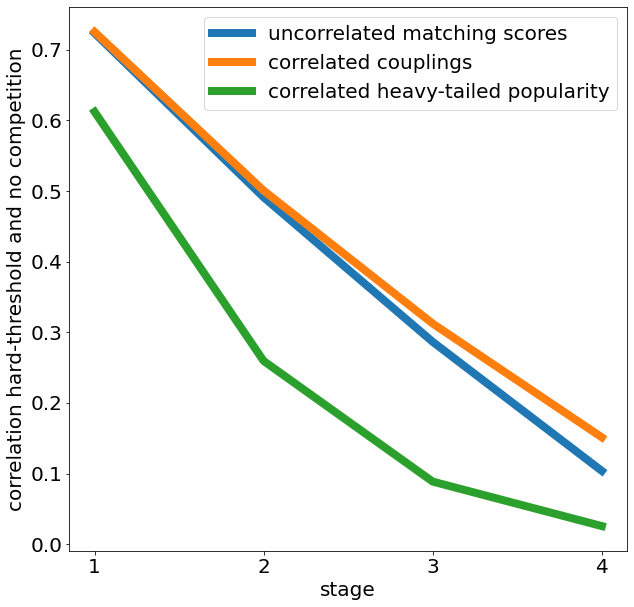

In [122]:
res = []
for cov, μ in zip([0,0.5,0],[0,0,1]):

    print(cov, μ)
    COV = np.array([[1, cov, cov, cov],
                    [cov, 1, cov, cov],
                    [cov, cov, 1, cov],
                    [cov, cov, cov, 1]
                    ])
    C = np.linalg.cholesky(COV)

    Xn = np.random.normal(size=(mj,mv,ns))
    Xn = np.einsum('ijk, lk->ijl',Xn,C,optimize='greedy')
    Xn = Xn + μ*np.ones(Xn.shape) #μ*np.asarray([np.diag(np.ones(20))]*4).transpose()
    
    th = [125,25,5,1]

    A = np.einsum('iu, jv, uvk->ijk',Xj,Xv,Xn,optimize='greedy')
    Yhardmutualcompetition = compute_label_tensor(hardmutualcompetition, th=th)

    A = np.einsum('iu, jv, uvk->ijk',Xj,Xv,Xn,optimize='greedy')
    Ynocompetition = compute_label_tensor(nocompetition_th_accordingtohardmutualcompetition,th, np.mean(Yhardmutualcompetition, axis=(0,1)))

    res.append([np.corrcoef(Ynocompetition[:,:,stage].flatten(), Yhardmutualcompetition[:,:,stage].flatten())[0,1] for stage in range(4)])

plt.figure(figsize=(10,10))
#plt.plot(res[0], label='$\sigma_{cov}$=0, $\mu$=0')
#plt.plot(res[1], label='$\sigma_{cov}$=0.5, $\mu$=0')
#plt.plot(res[2], label='$\sigma_{cov}$=0, $\mu$=1')
plt.plot(res[0], label='uncorrelated matching scores', linewidth=8)
plt.plot(res[1], label='correlated couplings', linewidth=8)
plt.plot(res[2], label='correlated heavy-tailed popularity', linewidth=8)
plt.xlabel('stage', fontsize=20)
plt.ylabel('correlation hard-threshold and no competition', fontsize=20)
plt.xticks([0,1,2,3], labels=[1,2,3,4], fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()